This notebook is part of the `kikuchipy` documentation https://kikuchipy.org.
Links to the documentation won't work from the notebook.

# Pattern matching

Crystal orientations can be determined from experimental EBSD patterns by
matching them to a dictionary of simulated patterns of known orientations
<cite data-cite="chen2015dictionary">Chen et al. (2015)</cite>,
<cite data-cite="nolze2016pattern">Nolze et al. (2016)</cite>, 
<cite data-cite="foden2019indexing">Foden et al. (2019)</cite>.

Here, we will demonstrate pattern matching using a Ni data set of 4125 EBSD
patterns and a dynamically simulated master pattern from EMsoft, both of low
resolution and found in the [kikuchipy.data](reference.rst#data) module.

<div class="alert alert-info">

Note

The generated pattern dictionary is discrete, but no refinement of the best
matching orientation is provided. The need for the latter is discussed in e.g.
<cite data-cite="singh2017application">Singh et al. (2017)</cite>.

</div>

Before we can generate a dictionary of
simulated patterns, we need a master pattern containing all possible scattering
vectors for a candidate phase. This can simulated done using EMsoft
<cite data-cite="callahan2013dynamical">Callahan and De Graef (2013)</cite>
<cite data-cite="jackson2014h5ebsd">Jackson et al. (2014)</cite>, and then read
into kikuchipy.

First, we import libraries and load the small experimental Nickel test data.

In [1]:
# exchange inline for qt5 for interactive plotting from the pyqt package
%matplotlib inline

import tempfile
import matplotlib.pyplot as plt
plt.rcParams["font.size"] = 15
import hyperspy.api as hs
import numpy as np
from orix import sampling, plot, io
import kikuchipy as kp


s = kp.data.nickel_ebsd_large()  # Use kp.load("data.h5") to load your own data
s

<EBSD, title: patterns Scan 1, dimensions: (75, 55|60, 60)>

To obtain a good match, we must increase the signal-to-noise ratio. In this
pattern matching analysis, the Kikuchi bands are considered the signal, and the
angle-dependent backscatter intensity, along with unwanted detector effects,
are considered to be noise. See the
[pattern processing guide](pattern_processing.rst) for further details.

In [2]:
s.remove_static_background()
s.remove_dynamic_background()

Removing the static background:
[########################################] | 100% Completed |  0.7s
Removing the dynamic background:
[########################################] | 100% Completed |  1.3s


Next, we load a dynamically simulated Nickel master pattern generated with
EMsoft, in the northern hemisphere projection of the square Lambert projection
for an accelerating voltage of 20 keV.

In [3]:
mp = kp.data.nickel_ebsd_master_pattern_small(projection="lambert", energy=20)
mp

<EBSDMasterPattern, title: ni_mc_mp_20kv_uint8_gzip_opts9, dimensions: (|401, 401)>

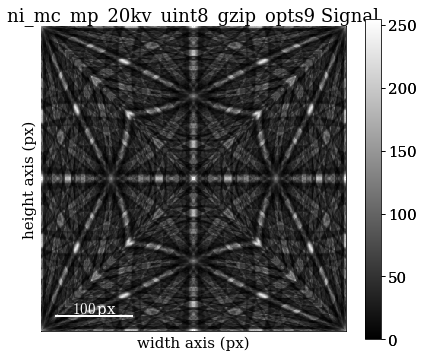

In [4]:
mp.plot()

The Nickel phase information, specifically the crystal symmetry, asymmetric atom
positions, and crystal lattice, is conveniently stored in an
[orix.crystal_map.Phase](https://orix.readthedocs.io/en/stable/reference.html#orix.crystal_map.phase_list.Phase).

In [5]:
ni = mp.phase
ni

<name: ni. space group: Fm-3m. point group: m-3m. proper point group: 432. color: tab:blue>

In [6]:
ni.structure  # Element, x, y, z, site occupation

[28   0.000000 0.000000 0.000000 1.0000]

In [7]:
ni.structure.lattice  # nm and degrees

Lattice(a=0.35236, b=0.35236, c=0.35236, alpha=90, beta=90, gamma=90)

If we don't know anything about the possible crystal (unit cell) orientations in
our sample, the safest thing to do is to generate a dictionary of orientations
uniformly distributed in a candidate phase's orientation space. To achieve this,
we sample the Rodrigues Fundamental Zone of the proper point group *432* with a
4$^{\circ}$ characteristic distance between orientations (we can either pass
in the proper point group, or the space group, which is a subgroup of the proper
point group) using
[orix.sampling.get_sample_fundamental()](https://orix.readthedocs.io/en/stable/reference.html#orix.sampling.sample_generators.get_sample_fundamental).

In [8]:
r = sampling.get_sample_fundamental(
    resolution=4, space_group=ni.space_group.number
)
r

Rotation (14423,)
[[ 1.     -0.     -0.     -0.    ]
 [ 0.9888 -0.1491 -0.     -0.    ]
 [ 0.9775 -0.2108 -0.     -0.    ]
 ...
 [ 0.9522 -0.2981 -0.      0.0666]
 [ 0.9405 -0.3333 -0.      0.0658]
 [ 0.9287 -0.3651 -0.      0.0649]]

This sampling resulted in 14423 crystal orientations.

<div class="alert alert-info">

Note

A characteristic distance of 4$^{\circ}$ results in a course sampling of
orientation space; a shorter distance should be used for real experimental work.

</div>

Now that we have our master pattern and crystal orientations, we need to
describe the EBSD detector's position with respect to the sample (interaction
volume). This ensures that projecting parts of the master pattern onto our
detector yields dynamically simulated patterns resembling our experimental ones.
See the [reference frames](reference_frames.rst) user guide and the
[EBSDDetector](reference.rst#ebsddetector) class for further details.

In [9]:
detector = kp.detectors.EBSDDetector(
    shape=s.axes_manager.signal_shape[::-1],
    pc=[0.421, 0.7794, 0.5049],
    sample_tilt=70,
    convention="tsl",
)
detector

EBSDDetector (60, 60), px_size 1 um, binning 1, tilt 0, pc (0.421, 0.221, 0.505)

Let's double check the projection/pattern center (PC) position on the detector
using
[plot()](reference.rst#kikuchipy.detectors.ebsd_detector.EBSDDetector.plot).

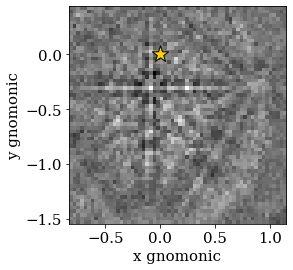

In [10]:
detector.plot(coordinates="gnomonic", pattern=s.inav[0, 0].data)

Now we're ready to generate our dictionary of simulated patterns by projecting
parts of the master pattern onto our detector for all sampled orientations,
using the
[get_patterns()](reference.rst#kikuchipy.signals.ebsdmasterpattern.get_patterns)
method. The method assumes the crystal orientations are represented with respect
to the EDAX TSL sample reference frame RD-TD-ND.

In [11]:
sim = mp.get_patterns(
    rotations=r,
    detector=detector,
    energy=20,
    dtype_out=s.data.dtype,
    compute=True
)
sim

Creating a dictionary of (14423,) simulated patterns:
[########################################] | 100% Completed | 16.4s


<EBSD, title: , dimensions: (14423|60, 60)>

Let's inspect the three first of the 14423 simulated patterns.

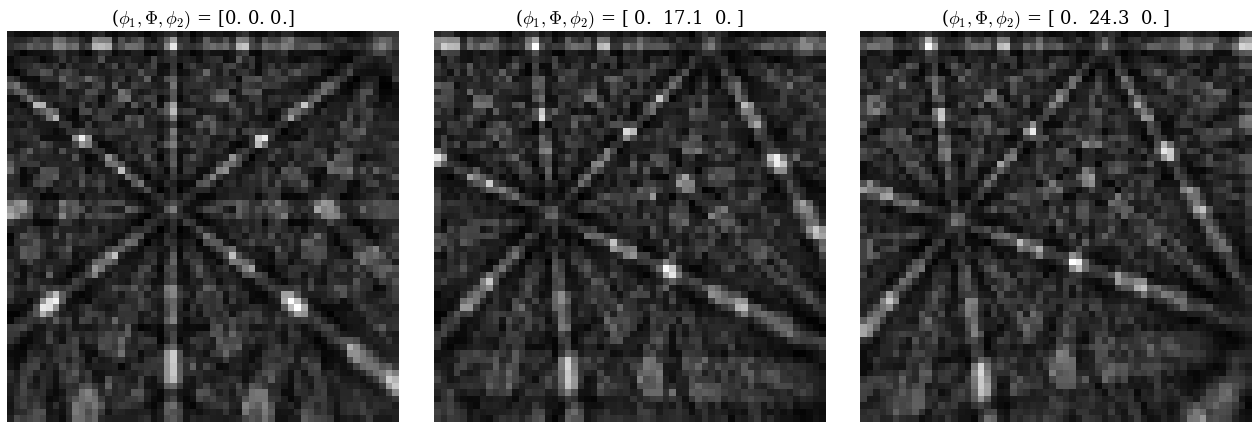

In [12]:
#sim.plot()  # Plot the patterns with a navigator for easy inspection
fig, ax = plt.subplots(ncols=3, figsize=(18, 6))
for i in range(3):
    ax[i].imshow(sim.inav[i].data, cmap="gray")
    euler = np.rad2deg(sim.xmap[i].rotations.to_euler())[0]
    ax[i].set_title(
        f"($\phi_1, \Phi, \phi_2)$ = {np.array_str(euler, precision=1)}"
    )
    ax[i].axis("off")
fig.tight_layout()

Finally, let's use the
[match_patterns()](reference.rst#kikuchipy.signals.EBSD.match_patterns) method
to match the simulated patterns to our nine experimental patterns, using the
[zero-mean normalized cross correlation (NCC)](reference.rst#kikuchipy.indexing.similarity_metrics.ncc)
coefficient $r$
<cite data-cite="gonzalez2017digital">Gonzalez & Woods (2017)</cite>, which is
the default similarity metric. Let's keep the 10 best matching orientations. A
number of 4125 * 14423 comparisons is quite small, which we can do in memory all
at once. However, in cases where the number of comparisons are too big for our
memory to handle, we can slice our simulated pattern data into $n$ slices. To
demonstrate this, we use 10 slices here. The results are returned as a
[orix.crystal_map.CrystalMap](https://orix.readthedocs.io/en/latest/reference.html#crystalmap).

In [13]:
xmap = s.match_patterns(sim, n_slices=10, keep_n=10)
xmap

Matching ni patterns: 100%|██████████| 10/10 [00:05<00:00,  1.74slice/s, mem=69.4%]


Phase  Orientations  Name  Space group  Point group  Proper point group     Color
    0  4125 (100.0%)    ni        Fm-3m         m-3m                 432  tab:blue
Properties: scores, simulation_indices
Scan unit: um

The results can be exported to an HDF5 file re-readable by orix.

In [14]:
temp_dir = tempfile.mkdtemp()
xmap_file = temp_dir + "ni.h5"
io.save(xmap_file, xmap)

Let's inspect our matching results by plotting a map of the highest $r$
(stored in the `scores` property).

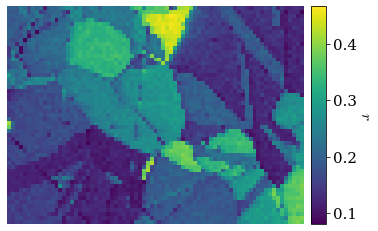

In [15]:
fig, ax = plt.subplots(subplot_kw=dict(projection="plot_map"))
ax.plot_map(xmap, xmap.scores[:, 0], scalebar=False)
ax.add_colorbar(label=r"$r$")
_ = ax.axis("off")

We can use the crystal map property `simulation_indices` to get the best
matching simulated patterns from the dictionary of simulated patterns.

In [16]:
best_patterns = sim.data[xmap.simulation_indices[:, 0]].reshape(s.data.shape)
s_best = kp.signals.EBSD(best_patterns)
s_best

<EBSD, title: , dimensions: (75, 55|60, 60)>

The simplest way to visually compare the experimental and best matching
simulated patterns are to
[plot them in the same navigator](visualizing_patterns.ipynb#plot-multiple-signals).
Here, we use the highest $r$ as a navigator. When using an interactive backend
like `Qt5Agg`, we can then move the red square around to look at the patterns in
each point.

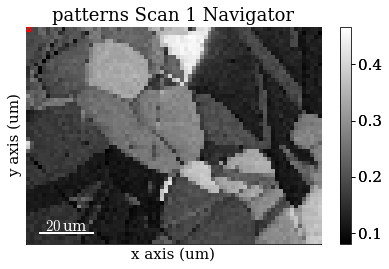

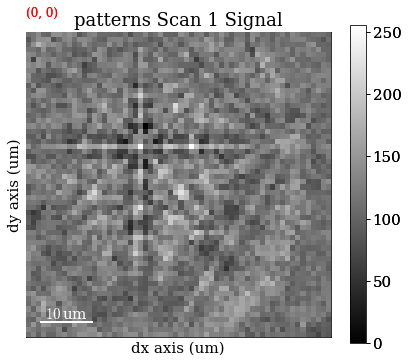

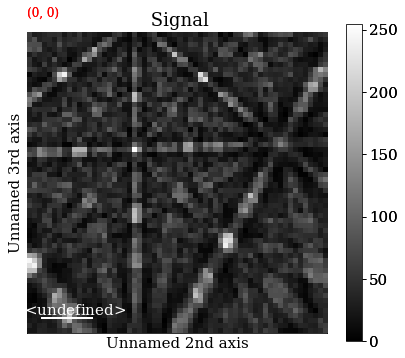

In [17]:
ncc_navigator = hs.signals.Signal2D(xmap.get_map_data(xmap.scores[:, 0]))
hs.plot.plot_signals([s, s_best], navigator=hs.signals.Signal2D(ncc_navigator))

Let's also plot the best matches for patterns from two grains

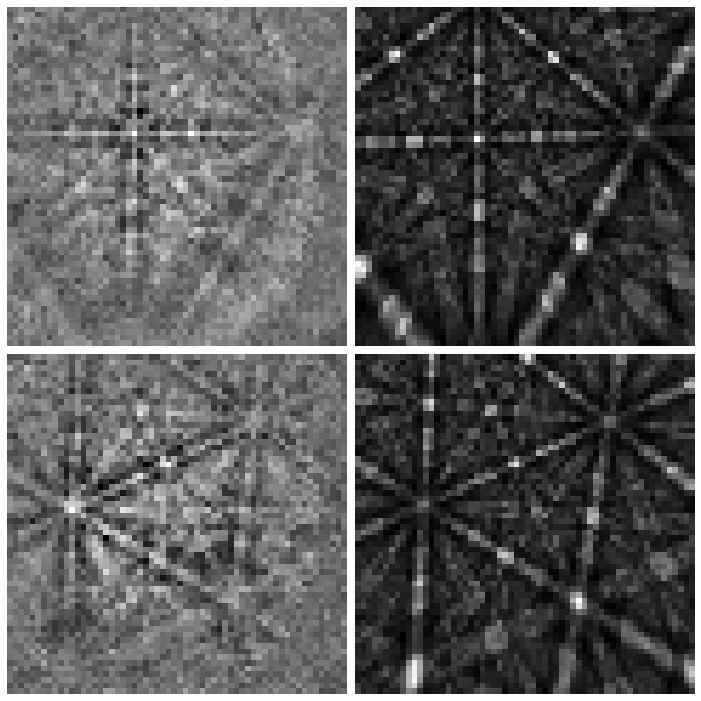

In [20]:
grain1 = (0, 0)
grain2 = (30, 10)
fig, ax = plt.subplots(ncols=2, nrows=2, figsize=(10, 10))
ax[0, 0].imshow(s.inav[grain1].data, cmap="gray")
ax[0, 0].axis("off")
ax[0, 1].imshow(s_best.inav[grain1].data, cmap="gray")
ax[0, 1].axis("off")
ax[1, 0].imshow(s.inav[grain2].data, cmap="gray")
ax[1, 0].axis("off")
ax[1, 1].imshow(s_best.inav[grain2].data, cmap="gray")
ax[1, 1].axis("off")
fig.tight_layout(h_pad=0.5, w_pad=1)

In [19]:
import os
os.rmdir(temp_dir)